In [2]:
#delfos copy for pka prediction
import torch
from torch import nn
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit import Chem
from numpy import genfromtxt
import numpy as np
import cProfile

RDKit WARNING: [14:42:16] Enabling RDKit 2019.09.3 jupyter extensions
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#step 1: define solvent X and solute Y using mol2vec (but don't add the substructures)
#step 2: run RNN in both directions on each molecule, then concatenate forward;reverse to get H and G
#step 3: feed H and G into attention layer, generate attention alignment matrix, create contexts P and Q
#step 4: maxpool H;P and G;Q into 2D feature vectors
#step 5: create flattened input u;v and feed into linear layer

In [4]:
#modified sentence2vec function to return lists of word vectors
def sentences2vecs(sentences, model, unseen=None):
    """Generate vectors for each word in a sentence sentence (list) in a list of sentences.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032
    Returns
    -------
    list of arrays, each sentence -> array of word vectors
    """
    keys = set(model.wv.key_to_index)
    bigveclist = []
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        veclist = []
        if unseen:
            veclist.append([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence])
        else:
            veclist.append([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys])
        vecarray = np.concatenate(veclist, axis=1)
        vectensor = torch.Tensor(vecarray)
        bigveclist.append(vectensor)
    return bigveclist

In [20]:
#step 1: mol2vec embedding
data = pd.read_csv('non_aqueous_pka_data.csv')

#mol2vec model
mol2vec_model = word2vec.Word2Vec.load('model_300dim.pkl')

#create mol type
data['sol_mol'] = data.apply(lambda x: Chem.MolFromSmiles(x['Solute SMILES']), axis=1)
data['solv_mol'] = data.apply(lambda x: Chem.MolFromSmiles(x['Solvent SMILES']), axis=1)

#remove invalid smiles
#data.replace("", float("NaN"), inplace=True)
#data.dropna(subset = ['mol'], inplace=True)
#print(data)

#create sentences
data['sol_sentence'] = data.apply(lambda x: mol2alt_sentence(x['sol_mol'],1), axis=1)
data['solv_sentence'] = data.apply(lambda x: mol2alt_sentence(x['solv_mol'],1), axis=1)

targets = torch.Tensor(data['pKa (avg)'])
sol_data = sentences2vecs(data['sol_sentence'], mol2vec_model, unseen='UNK')
solv_data = sentences2vecs(data['solv_sentence'], mol2vec_model, unseen='UNK')

RDKit WARNING: [14:57:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:57:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:57:12] WARNING: not removing hydrogen atom without neighbors


In [ ]:
#from torch.nn.utils.rnn import pack_sequence
#X = pack_sequence(X,enforce_sorted = False)
##TODO BATCHING VARIABLE SEQUENCE LENGTHS

In [79]:
def alpha(G,H):
    alpha = torch.exp(H@torch.t(G))
    norm = torch.sum(alpha, dim=1)
    norm = torch.pow(norm, -1)
    alpha = alpha * norm[:, None]
    return alpha

def att(G,H):
    P = alpha(G,H)@G
    inH = torch.cat((H,P),1)
    return inH

In [22]:
# model definition
epochs = 10
n_features = 300
n_hidden = 100

class maxpool(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d((L,2), stride=2)
    def forward(self, X):
        return self.maxpool(X)

class dnet(nn.Module):
    def __init__(self, n_features, D, FF):
        super(dnet, self).__init__()
    
        self.biLSTM_X = nn.LSTM(n_features, D, bidirectional=True)
        self.biLSTM_Y = nn.LSTM(n_features, D, bidirectional=True)
        
        self.FF = nn.Linear(4*D, FF)
        self.out = nn.Linear(FF, 1)
    
    def forward(self,X,Y):
        N = X.data.shape[0]
        M = Y.data.shape[0]
        
        #turn input list of vec into correct shape
        X = X.view(X.data.shape[0],1,X.data.shape[1]) #N rows
        Y = Y.view(Y.data.shape[0],1,Y.data.shape[1]) #M rows
        
        #biLSTM to get hidden states
        H, hcX = self.biLSTM_X(X, None) #Nx1x2D matrix
        G, hcY = self.biLSTM_Y(Y, None) #Mx1x2D matrix
        
        #contexts
        inG = att(H[:,0,:],G[:,0,:]) #Nx4D
        inH = att(G[:,0,:],H[:,0,:]) #Mx4D
        
        #maxpool concatenated tensors
        maxpool_X = maxpool(N)
        maxpool_Y = maxpool(M)
        u = maxpool_X(inH.view(1,inH.data.shape[0],inH.data.shape[1]))  #1x1x2D
        v = maxpool_Y(inG.view(1,inG.data.shape[0],inG.data.shape[1]))  #1x1x2D
        
        #feed forward neural network
        NN = torch.cat((u,v),2)
        NN = self.FF(NN)
        NN = nn.functional.relu(NN)
        output = self.out(NN)
        return output

dmodel = dnet(300,150,2000)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(dmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

In [ ]:
# model definition, 3D maxpool
epochs = 10
n_features = 300
n_hidden = 100

class maxpool(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d((L,1,2), stride=1)
    def forward(self, X):
        return self.maxpool(X)
    
def att(G,H):
    Q = alpha(G,H)@G
    inH = torch.stack([H,Q],2)
    return inH

class dnet(nn.Module):
    def __init__(self, n_features, D, FF):
        super(dnet, self).__init__()
    
        self.biLSTM_X = nn.LSTM(n_features, D, bidirectional=True)
        self.biLSTM_Y = nn.LSTM(n_features, D, bidirectional=True)
        
        self.FF = nn.Linear(4*D, FF)
        self.out = nn.Linear(FF, 1)
    
    def forward(self,X,Y):
        N = X.data.shape[0]
        M = Y.data.shape[0]
        
        #turn input list of vec into correct shape
        X = X.view(X.data.shape[0],1,X.data.shape[1]) #N rows
        Y = Y.view(Y.data.shape[0],1,Y.data.shape[1]) #M rows
        
        #biLSTM to get hidden states
        H, hcX = self.biLSTM_X(X, None) #Nx1x2D matrix
        G, hcY = self.biLSTM_Y(Y, None) #Mx1x2D matrix
        
        #contexts
        inG = att(H[:,0,:],G[:,0,:]) #Nx4D
        inH = att(G[:,0,:],H[:,0,:]) #Mx4D
        
        #maxpool concatenated tensors
        maxpool_X = maxpool(N)
        maxpool_Y = maxpool(M)
        u = maxpool_X(inH.view(1,inH.data.shape[0],inH.data.shape[1],inH.data.shape[2]))  #1x1x2D
        v = maxpool_Y(inG.view(1,inG.data.shape[0],inG.data.shape[1],inG.data.shape[2]))  #1x1x2D
        
        #feed forward neural network
        NN = torch.cat((u,v),2).view(1,1,600)
        NN = self.FF(NN)
        NN = nn.functional.relu(NN)
        output = self.out(NN)
        return output

dmodel = dnet(300,150,2000)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(dmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

In [27]:
epochs = 10
n_features = 300
n_hidden = 100
losslist = []
for t in range(epochs):
    for b in range(len(sol_data)):
        solute = sol_data[b]
        solvent = solv_data[b]
        target = targets[b]  
        output = dmodel(solute,solvent) 
        loss = criterion(output, target)  
        print("output:",output.item()," target:",target.item())
        losslist.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('step : ' , t , 'loss : ' , loss.item())
    
import matplotlib.pyplot as plt
plt.plot(losslist)

output: 34.07905578613281  target: 35.0
output: 37.32956314086914  target: 35.70000076293945
output: 32.2772331237793  target: 31.700000762939453
output: 9.855939865112305  target: 8.800000190734863
output: 45.4583625793457  target: 43.599998474121094
output: 14.228582382202148  target: 13.5
output: 11.161382675170898  target: 7.960000038146973
output: 10.684391021728516  target: 10.100000381469727
output: 19.549884796142578  target: 16.610000610351562
output: 9.865285873413086  target: 9.210000038146973
output: 9.979820251464844  target: 10.5
output: 18.52896499633789  target: 16.459999084472656
output: 10.483538627624512  target: 6.170000076293945
output: 9.402362823486328  target: 7.46999979019165
output: 40.28449630737305  target: 40.400001525878906
output: 8.161394119262695  target: 8.774999618530273
output: 7.7627081871032715  target: 6.190000057220459
output: 7.659736156463623  target: 6.704999923706055
output: 7.580693244934082  target: 7.860000133514404
output: 6.7299771308898

KeyboardInterrupt: 

In [210]:
cProfile.run("dmodel(X[2],Y[0])", sort = "cumtime")

         526 function calls (518 primitive calls) in 0.078 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.078    0.078 {built-in method builtins.exec}
        1    0.005    0.005    0.078    0.078 <string>:1(<module>)
      9/1    0.000    0.000    0.073    0.073 module.py:715(_call_impl)
        1    0.000    0.000    0.073    0.073 <ipython-input-208-c9036915f170>:23(forward)
        2    0.000    0.000    0.070    0.035 rnn.py:555(forward)
        2    0.069    0.035    0.069    0.035 {built-in method lstm}
        2    0.000    0.000    0.002    0.001 <ipython-input-207-127204d06c41>:8(att)
        2    0.001    0.000    0.001    0.001 <ipython-input-207-127204d06c41>:1(alpha)
        2    0.001    0.000    0.001    0.000 {built-in method exp}
        2    0.000    0.000    0.000    0.000 <ipython-input-208-c9036915f170>:10(forward)
        2    0.000    0.000    0.000    0.000 poolin

In [ ]:
class SolvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.landmarks_frame.iloc[idx, 0]
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [46]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_IDs, solute, solvent, labels):
        self.labels = labels
        self.solute = solute
        self.solvent = solvent
        self.list_IDs = list_IDs
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        
        X = (self.solute[ID],self.solvent[ID])
        y = self.labels[ID]
        
        return X, y

In [43]:
sample = [torch.Tensor(x) for x in sol_data[0:5]]
print([t.shape for t in sample])
loader = DataLoader(sample, batch_size=2, shuffle=True, collate_fn=collate_fn_padd)

for batch_idx, (x, t, m) in enumerate(loader):
    print(x.shape, t.shape, m.shape)
    print(m)

[torch.Size([11, 300]), torch.Size([31, 300]), torch.Size([19, 300]), torch.Size([8, 300]), torch.Size([8, 300])]
torch.Size([11, 2, 300]) torch.Size([2]) torch.Size([11, 2, 300])
tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        ...,

        [[ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False]]])
torch.Size([31, 2, 300]) torch.Size([2]) torch.Size([31, 2, 300])
tensor([[[ True,  Tr

In [77]:
from torch.utils.data import TensorDataset, DataLoader

def collate_fn_padd(batch):
    '''
    Padds batch of variable length
    '''
    ## get sequence lengths
    lengths = torch.tensor([t.shape[0] for t in batch])
    ## padd
    batch = [torch.Tensor(t) for t in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch)
    ## compute mask
    mask = (batch != 0)
    return batch, lengths, mask

def collate_double(batch):
    '''
    Padds batch of variable length
    '''
    sol_batch = [torch.Tensor(t[0][0]) for t in batch]
    sol_batch = torch.nn.utils.rnn.pad_sequence(sol_batch)
    solv_batch = [torch.Tensor(t[0][1]) for t in batch]
    solv_batch = torch.nn.utils.rnn.pad_sequence(solv_batch)
    targets = torch.Tensor([t[1].item() for t in batch])
    
    return [sol_batch, solv_batch, targets]

loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn_padd)

#for batch_idx, (x, t) in enumerate(loader):
#   print(x.shape, t.shape)

In [187]:
# batch model definition
epochs = 10
n_features = 300
n_hidden = 100
batch_size = 32

#attention alignment (alpha) of H wrt G
def alpha(G,H):
    alpha = torch.exp(H@torch.t(G))
    norm = torch.sum(alpha, dim=1)
    norm = torch.pow(norm, -1)
    alpha = alpha * norm[:, None]
    return alpha

#inH = H;P, where P is the emphasised hidden state H / solvent context
def att(G,H):
    P = alpha(G,H)@G
#    inH = torch.cat((H,P),1)
    inH = torch.stack((H,P),2)
    return inH

#module for variable maxpooling with interaction vectors
class maxpool_int(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d((L,1,2))
    def forward(self, X):
        return self.maxpool(X)

#module for variable maxpooling without interaction vectors
class maxpool(nn.Module):
    def __init__(self, L):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool2d((L,1))
    def forward(self, X):
        return self.maxpool(X)

#delfos model
class dnet(nn.Module):
    def __init__(self, n_features=300, D=150, FF=2000, interaction=True):
        super(dnet, self).__init__()
        self.features = n_features
        self.dim = D
        self.hidden = FF
        self.interaction = interaction
    
        self.biLSTM_X = nn.LSTM(self.features, self.dim, bidirectional=True)
        self.biLSTM_Y = nn.LSTM(self.features, self.dim, bidirectional=True)
        
        self.FF = nn.Linear(4*self.dim, self.hidden)
        self.out = nn.Linear(self.hidden, 1)
    
    def forward(self,Y,X):
        #max sequence lengths
        N = X.shape[0] #solvent
        M = Y.shape[0] #solute
        #batch size
        B = X.shape[1] 
        
        #biLSTM to get hidden states
        H, hcX = self.biLSTM_X(X, None) #NxBx2D tensor - solvent hidden state
        G, hcY = self.biLSTM_Y(Y, None) #MxBx2D tensor - solute hidden state
        
        if self.interaction:
            #calculate attention, then concatenate with hidden states H and G
            inH = torch.stack([att(G[:,b,:],H[:,b,:]) for b in range(B)],0) #BxNx2Dx2
            inG = torch.stack([att(H[:,b,:],G[:,b,:]) for b in range(B)],0) #BxMx2Dx2
        
            #maxpool concatenated tensors
            maxpool_X = maxpool_int(N)
            maxpool_Y = maxpool_int(M)
            u = maxpool_X(inH).view(B,2*self.dim)  #Bx2D - solvent vector
            v = maxpool_Y(inG).view(B,2*self.dim)  #Bx2D - solute vector
        
        else:
            #maxpool tensors
            maxpool_X = maxpool(N)
            maxpool_Y = maxpool(M)
            u = maxpool_X(torch.transpose(H,0,1)).view(B,2*self.dim)  #Bx2D - solvent vector
            v = maxpool_Y(torch.transpose(G,0,1)).view(B,2*self.dim)  #Bx2D - solute vector
        
        #feed forward neural network
        NN = torch.cat((u,v),1) #Bx4D - concatenated solvent/solute vector
        NN = self.FF(NN) #Bxhidden
        NN = nn.functional.relu(NN)
        output = self.out(NN).view(B)
        return output

dmodel = dnet(300,100,2000,False)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(dmodel.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

In [188]:
dmodel(sample[0],sample[1])

tensor([-0.0044, -0.0069], grad_fn=<ViewBackward>)

step :  0 loss :  27.570920944213867
step :  1 loss :  0.7333709001541138
step :  2 loss :  2.6808462142944336
step :  3 loss :  3.8494668006896973
step :  4 loss :  6.193925857543945
step :  5 loss :  15.363566398620605
step :  6 loss :  3.488748073577881
step :  7 loss :  2.0179247856140137
step :  8 loss :  9.508049011230469
step :  9 loss :  8.998316764831543


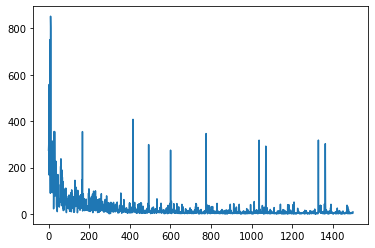

In [189]:
dataset = Dataset([x for x in range(len(sol_data))], sol_data, solv_data, targets)
loader = DataLoader(dataset, batch_size=6, shuffle=True, collate_fn=collate_double)

sample = iter(loader)

for batch_idx, (sol,solv,t) in enumerate(loader):
    sample = (sol,solv,t)
    #apply training to batches!
    
    
epochs = 10
n_features = 300
n_hidden = 100
losslist = []
for x in range(epochs):
    for (sol,solv,t) in loader:
        output = dmodel(sol,solv) 
        loss = criterion(output, t)  
        losslist.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('step : ' , x , 'loss : ' , loss.item())
    
import matplotlib.pyplot as plt
plt.plot(losslist)

In [176]:
for t in range(epochs):
    for b in range(len(X)):
        solute = X[b]
        solvent = Y[0]
        target = targets[b]  

        output = dmodel(solute,solvent) 
        print(output)
        loss = criterion(output, target)  
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    print('step : ' , t , 'loss : ' , loss.item())

NameError: name 'X' is not defined